In [4]:
import json
import pandas as pd
import sys

sys.path.append("../../")

from config import DATA_DIR
from graph_types.graph import Graph
import matplotlib.pyplot as plt

graph_name = "prime"

In [5]:
logs_dir = DATA_DIR / f"experiments/{graph_name}/subgraph_explorer"
json_files = sorted([f for f in logs_dir.glob("*.json")], key=lambda x: x.stat().st_ctime)

data = []

for json_file in json_files:
    with open(json_file, "r") as f:
        log_data = json.load(f)

    # Extract key information from each log entry
    record = {
        "file_id": int(json_file.stem),
        "question": log_data.get("question", ""),
        "all_nodes": log_data.get("all_nodes", []),
        "message_histories": log_data.get("message_histories", ""),
        "starting_nodes_indices": log_data.get("starting_nodes_indices", []),
        "agent_answer_indices": log_data.get("agent_answer_indices", []),
        "answer_indices": log_data.get("answer_indices", []),
    }

    data.append(record)

df = pd.DataFrame(data).reset_index(drop=True)  # .sort_values(by="file_id").reset_index(drop=True)

df["recall@all"] = df.apply(
    lambda row: len(set(row["answer_indices"]).intersection(set(row["agent_answer_indices"])))
    / len(set(row["answer_indices"])),
    axis=1,
)
df["hit@1"] = df.apply(
    lambda row: (
        row["agent_answer_indices"][0] in row["answer_indices"]
        if row["agent_answer_indices"]
        else False
    ),
    axis=1,
)
df["hit@5"] = df.apply(
    lambda row: len(set(row["answer_indices"]).intersection(set(row["agent_answer_indices"][:5])))
    > 0,
    axis=1,
)
df["hit@10"] = df.apply(
    lambda row: len(set(row["answer_indices"]).intersection(set(row["agent_answer_indices"][:10])))
    > 0,
    axis=1,
)
df["recall@10"] = df.apply(
    lambda row: len(set(row["answer_indices"]).intersection(set(row["agent_answer_indices"][:10])))
    / len(set(row["answer_indices"])),
    axis=1,
)
df["recall@20"] = df.apply(
    lambda row: len(set(row["answer_indices"]).intersection(set(row["agent_answer_indices"][:20])))
    / len(set(row["answer_indices"])),
    axis=1,
)

[
    ("n", len(df)),
    ("Hit@1", float(round(df["hit@1"].mean(), 3))),
    ("Hit@5", float(round(df["hit@5"].mean(), 3))),
    ("Recall@10", float(round(df["recall@10"].mean(), 3))),
    ("Recall@20", float(round(df["recall@20"].mean(), 3))),
    ("Recall@all", float(round(df["recall@all"].mean(), 3))),
]

[('n', 2),
 ('Hit@1', 0.0),
 ('Hit@5', 0.0),
 ('Recall@10', 0.0),
 ('Recall@20', 0.5),
 ('Recall@all', 0.5)]

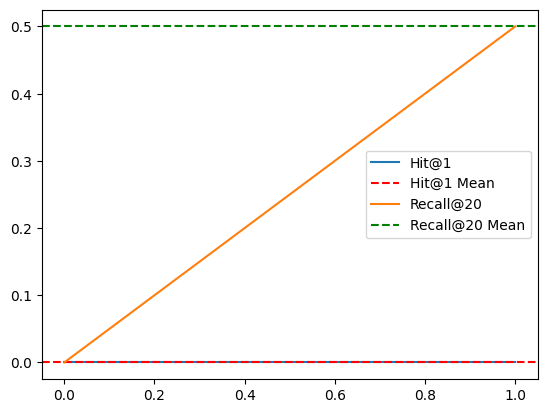

In [6]:
plt.plot([df['hit@1'].iloc[:i].mean() for i in range(1, len(df) + 1)], label='Hit@1')
plt.axhline(y=df['hit@1'].mean(), color='r', linestyle='--', label='Hit@1 Mean')
plt.plot([df['recall@20'].iloc[:i].mean() for i in range(1, len(df) + 1)], label='Recall@20')
plt.axhline(y=df['recall@20'].mean(), color='g', linestyle='--', label='Recall@20 Mean')
plt.legend()
